In [1]:
include("./prepare_data.jl")
include("./model.jl")

import .Model
import Flux

In [2]:
using CUDA 
device = Flux.gpu

flux_model = Model.model |> device

Chain(
  Recur(
    LSTMCell(512 => 64),                # 147_840 parameters
  ),
  MaxPool((2,)),
  Recur(
    LSTMCell(32 => 16),                 # 3_168 parameters
  ),
  Flux.flatten,
  Dense(48 => 3),                       # 147 parameters
  NNlib.softmax,
)         # Total: 12 trainable arrays, 151_155 parameters,
          # plus 4 non-trainable, 160 parameters, summarysize 1.789 KiB.

In [3]:
function flux_loss(model, x, y)
    ŷ = model(x)
    Flux.crossentropy(ŷ, y)
end

flux_loss (generic function with 1 method)

In [4]:
using ProgressMeter
using MLUtils 

data_loader = MLUtils.DataLoader(DataSet(ModelCfgs.D), batchsize=32) |> device
 opt_state  = Flux.setup(Flux.Adam(0.01),flux_model)


(layers = ((cell = (Wi = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), Wh = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), b = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), state0 = (Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999))), Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8)

In [5]:
losses = []
epochs = 50
@showprogress for epoch in 1:epochs 
                    total_loss = 0.0
                    for (x,y) in data_loader
                        l = flux_loss(flux_model, x, y)
                        total_loss += l
                        Flux.train!(flux_loss, flux_model, [(x, y)], opt_state)
                    end
                    push!(losses,total_loss)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:47


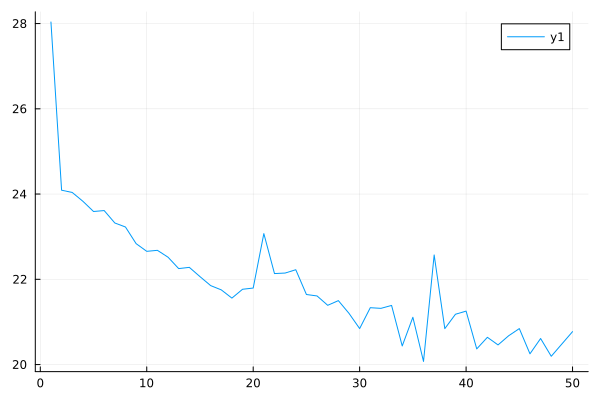

In [6]:
import Plots

Plots.plot(losses)

In [7]:
#calculate accuracy
# function accuracy(model, x, y)
#     ŷ = model(x)
#     acc = sum(ŷ .== y) / length(y)
#     acc
# end

# function accuracy(model, data_loader)
#     acc = 0.0
#     for (x,y) in data_loader
#         acc += accuracy(model, x, y)
#     end
#     acc / length(data_loader)
# end

# accuracy(flux_model, data_loader)


In [8]:
using Dates
now = Dates.now()
date_now = Dates.value(now)


63823371433984

In [9]:
io = open(string("./output/losses_",ModelCfgs.D,"_",date_now,".txt"),"w")
    for loss in losses 
        println(io,loss)
    end
close(io)

In [10]:
cpu_model = Flux.cpu(flux_model)

using BSON: @save
@save string("./output/mymodel_",ModelCfgs.D,"_",date_now,".bson") cpu_model

In [11]:
using Flux, BSON
BSON.@load string("./output/mymodel_",ModelCfgs.D,"_",date_now,".bson") cpu_model

In [12]:
Flux.params(cpu_model )

Params([Float32[0.1286168 0.09586418 … -0.12469884 -0.036641497; -0.16878258 0.38025135 … -0.8356287 -0.77151173; … ; -0.07515811 0.023218349 … -0.3216839 -0.31541866; 0.58264345 0.4332442 … -0.18306418 -0.3142006], Float32[-1.1471212 -0.6233003 … -0.31390336 0.365262; -0.11147434 -0.59951013 … -0.27185628 0.5998925; … ; 0.55745816 0.15790741 … 0.16600998 -0.50700676; -0.2460323 -0.43544582 … 0.41964248 -0.69730866], Float32[0.6331664, 0.9285208, 0.4720819, -0.016868012, 0.4882218, 0.19114284, -0.0017853174, -0.44819453, 0.4268753, 0.3723508  …  0.52834255, 0.5466062, 0.38570228, -0.15159203, -0.6344002, -0.038295466, 0.3946222, -0.074022904, 0.020346057, -0.4619526], Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[-0.2696655 0.44449553 … -0.45982054 -0.24483061; 0.52593327 -0.14037023 … -0.4911273 0.13338676; … ; 1.2658607 0.43250373 … 0.089653686 0.4334586; -0.23655944 -0.28976023 … -0.6637353 -0.36484337], Float32[-0.1602342 0.43434003 … -0.24812981 -0.